# Computing and Visualizing Spectral Diversity
## BioSCape Data Skills Workshop: From the Field to the Image

[**BioSCape**](https://www.bioscape.io/), the Biodiversity Survey of the Cape, is NASA’s first biodiversity-focused airborne and field campaign that was conducted in South Africa in 2023. BioSCape’s primary objective is to study the structure, function, and composition of the region’s ecosystems, and how and why they are changing. 

BioSCape's airborne dataset is unprecedented, with `AVIRIS-NG`, `PRISM`, and `HyTES` imaging spectrometers capturing spectral data across the UV, visible and infrared at high resolution and `LVIS` acquiring coincident full-waveform lidar. BioSCape's `field dataset` is equally impressive, with 18 PI-led projects collecting data ranging from the diversity and phylogeny of plants, kelp and phytoplankton, eDNA, landscape acoustics, plant traits, blue carbon accounting, and more

This workshop will equip participants with the skills to find, subset, and visualize the various BioSCape field and airborne (imaging spectroscopy and full-waveform lidar) data sets. Participants will learn data skills through worked examples in terrestrial and aquatic ecosystems, including: wrangling lidar data, performing band math calculations, calculating spectral diversity metrics, machine learning and image classification, and mapping functional traits using partial least squares regression. The workshop format is a mix of expert talks and interactive coding notebooks and will be run through the BioSCape Cloud computing environment.

**Date:** October 9 - 11, 2024 Cape Town, South Africa</center>

**Host:** NASA’s Oak Ridge National Laboratory Distributed Active Archive Center (ORNL DAAC), in close collaboration with BioSCape, the South African Environmental Observation Network (SAEON), the University of Wisconsin Madison (Phil Townsend), The Nature Conservancy (Glenn Moncrieff), the University of California Merced (Erin Hestir), the University of Cape Town (Jasper Slingsby), Jet Propulsion Laboratory (Kerry Cawse-Nicholson), and UNESCO.

**Instructors:** 
- In-person contributors: Anabelle Cardoso, Erin Hestir, Phil Townsend, Henry Frye, Glenn Moncrieff, Jasper Slingsby, Michele Thornton, Rupesh Shrestha
- Virtual contributors: Kerry Cawse-Nicholson, Nico Stork, Kyle Kovach

**Audience:** This training is primarily intended for government natural resource management agency representatives and field technicians in South Africa, as well as local academics and students, especially those connected to the BioSCape Team. 

## Overview 

“Intrinsic Dimensionality” (ID) is a measure of spectral diversity, which we think of as a proxy for plant biodiversity in the form of species richness (number of unique plant species present within a small, defined area). The ID of a hyperspectral image cube can be defined as the number of spectrally distinct signal sources within a spectral image or sub-image. While the ID includes all components within the region of interest (window)---including soil, rocks, building materials, plants, etc.---it gives us a good idea of scene complexity, which can then be interpreted based on the landcover type. 


| Dataset | Description | 
| -------- | --- |
| L2 | Orthocorrected and atmospherically corrected AVIRIS-NG reflectance data |
| N | An estimate of the image "noise" (which includes scattering, non-linear interactions, and all non-signal contributors), pre-computed for this exercise |

### Learning Objectives
1.  Mount BioSCape SMCE S3 BioSCape object storage and explore file content
2.  Open AVIRIS-NG Reflectance data
3.  Compute ID for three images, using a technique called Random Matrix Theory (RMT)
4.  Visualize the changing ID over the Cape Penninsula

### Requirements


### Load Python Modules

In [1]:
import rioxarray as rxr
import os
import s3fs
import numpy as np
import rasterio
import RMT
import h5py
import matplotlib.pyplot as plt

## Explore the BioSCape SMCE S3 AVIRIS-NG data holdings

Let's start by exploring the BioSCape Airborne currently data available on the cloud in Amazon Storage. This AWS S3 storage is specific to the SMCE that provides data access and analytics environment to the BioSCape Science Team as well as interested researchers.  
We'll learn how to mount the S3 object storage on our local environment, as well as learning how to bring other data to the analysis.

- **SMCE** = Science Managed Cloud Environment
- **S3** = Amazon Simple Storage Service (S3) is a cloud storage service that allows users to store and retrieve data
- **S3Fs** is a `Pythonic` open source tool that mounts S3 object storage locally.  S3Fs provides a filesystem-like interface for accessing objects on S3.
    - The top-level class **`S3FileSystem`** holds connection information and allows typical file-system style operations like `ls`
    - `ls` is a UNIX command to list computer files and directories

In [2]:
# Use S3Fs to list the BioSCape data on the BioSCape SMCE S3 storaage
s3 = s3fs.S3FileSystem(anon=False)
files = s3.ls('bioscape-data/')
files

['bioscape-data/AVNG',
 'bioscape-data/BioSCapeVegPolys2023_10_18',
 'bioscape-data/BioSCapeVegPolys2023_10_18.geoparquet',
 'bioscape-data/LVIS',
 'bioscape-data/PRISM',
 'bioscape-data/bioscape_avng.yaml']

### AVIRIS-NG

Let's choose three AVIRIS-NG images for this exercise.

In [3]:
bioscape_dir = 'bioscape-data/AVNG'
sub_files1 = ['bioscape-data/AVNG/ang20231109t131923/ang20231109t131923_019', 
    'bioscape-data/AVNG/ang20231109t133124/ang20231109t133124_003', 
    'bioscape-data/AVNG/ang20231109t133124/ang20231109t133124_013']

### There are Level 2 (L2) Reflectance data for AVIRIS-NG in the BioSCape SCME

In [4]:
### List the files in each flightline directory to find the reflectance files
### These files are in ENVI format, so the binary file has no extension
### In other words, we eliminate the files with extensions when determining 
### which file to open

rfl = s3.ls(sub_files1[0])
raster_file = [f for f in rfl if "RFL_ORT" in f and "QL" not in f and not f.endswith(".hdr") and not f.endswith(".json")]

### Using RasterIO to read a raster file as a numerical array
- read the image data
- read the pre-computed noise
- define the wavelengths that should be used
- and set the fill values to 0

In [5]:
### Read in the data with lazy loading, and chunk the data along the y axis
data = rxr.open_rasterio(os.path.join('s3://', raster_file[0]), chunks={"y":1})

## Set -9999 values to 0
data = data.where(data != -9999, 0)

### Import noise matrix. This was computed in advance, but is used for all AVIRIS-NG data
f = h5py.File('SHIFT_estnoise_output.mat') 
N = np.array(f['N2'])

### Define the "good" bands (no atmospheric absorption)
w = np.array(data.wavelength)
goodbands = np.logical_or(np.logical_or(np.logical_and(w > 405, w < 1340), np.logical_and(w > 1460, w < 1800)), np.logical_and(w > 2050, w < 2450))

### Open the reflectance file and subset to use only the good bands
refldat = data.values[goodbands,:,:]

## Compute ID


15


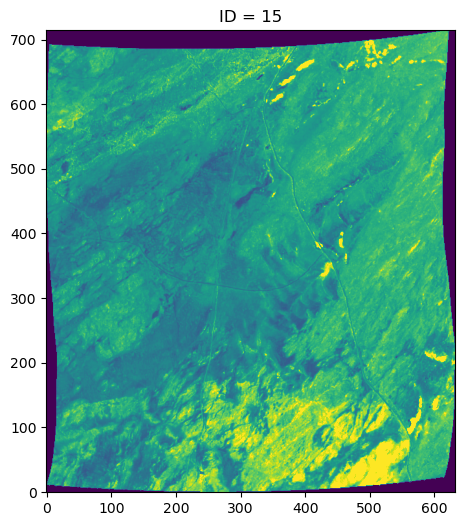

In [6]:
### Calculate ID
ID, n_pixels = RMT.RMT(refldat,N)
print(ID)

### Show image
plt.figure(figsize=(8, 6))
im = plt.imshow(refldat[100], origin='lower', vmin=0, vmax=0.3)
plt.title(f'ID = ' + str(ID))
plt.show()

## Now do the same for the other two images


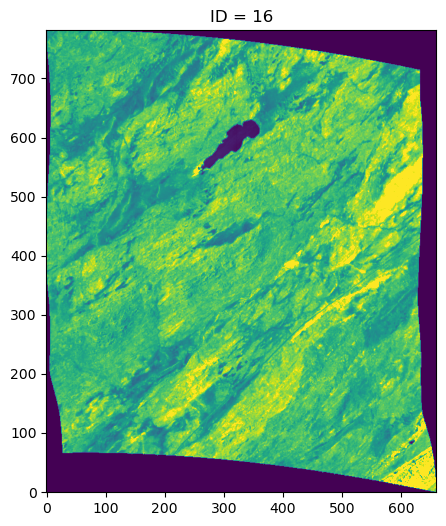

In [7]:
rfl = s3.ls(sub_files1[1])
raster_file = [f for f in rfl if "RFL_ORT" in f and "QL" not in f and not f.endswith(".hdr") and not f.endswith(".json")]
data = rxr.open_rasterio(os.path.join('s3://', raster_file[0]), chunks={"y":1})
data = data.where(data != -9999, 0)
refldat = data.values[goodbands,:,:]
ID, n_pixels = RMT.RMT(refldat,N)

### Show image
plt.figure(figsize=(8, 6))
im = plt.imshow(refldat[100], origin='lower', vmin=0, vmax=0.3)
plt.title(f'ID = ' + str(ID))
plt.show()

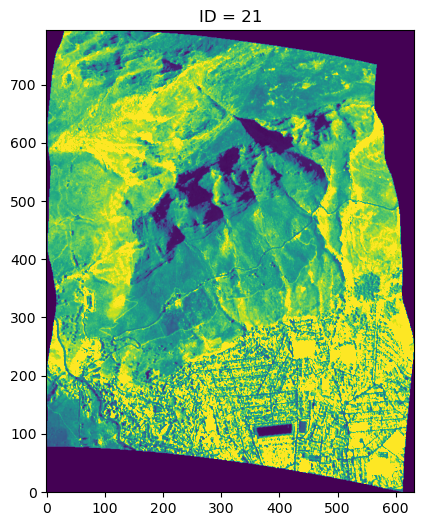

In [8]:
rfl = s3.ls(sub_files1[2])
raster_file = [f for f in rfl if "RFL_ORT" in f and "QL" not in f and not f.endswith(".hdr") and not f.endswith(".json")]
data = rxr.open_rasterio(os.path.join('s3://', raster_file[0]), chunks={"y":1})
data = data.where(data != -9999, 0)
refldat = data.values[goodbands,:,:]
ID, n_pixels = RMT.RMT(refldat,N)

### Show image
plt.figure(figsize=(8, 6))
im = plt.imshow(refldat[100], origin='lower', vmin=0, vmax=0.3)
plt.title(f'ID = ' + str(ID))
plt.show()

## ID varies according to image complexity

Do you see how the ID varies across all three scenes? Now let's look at the precomputed ID across the Cape Penninsula. Each cell represents the ID of a 250m x 250m region of interest. What do you notice?

### Open QGIS in the Hub Desktop, 
- From a **`Launcher`** tab, start the Desktop
- At the bottom of the Desktop screen, use the Application Finder to find and launch QGIS
- start QGIS,
- using the **`Home`** file system, maneuver to the correct file folder containing the ID output file,
- and view the diversity output!



- a copy of the ID tiff file is in the workshop folder `//shared/users/bioscape_ZA24workshop_data/RS_data/ID_Notebook`